In [53]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [54]:
df = pd.read_csv('prepped_churn_data_new.csv', index_col='customerID')
df

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_to_tenure
customerID,,,,,,,,
0,1,0,0.083333,1,29.85,29.85,0,29.850000
1,34,1,1.000000,2,56.95,1889.50,0,55.573529
2,2,1,0.083333,2,53.85,108.15,1,54.075000
3,45,0,1.000000,3,42.30,1840.75,0,40.905556
4,2,1,0.083333,1,70.70,151.65,1,75.825000
...,...,...,...,...,...,...,...,...
7038,24,1,1.000000,2,84.80,1990.50,0,82.937500
7039,72,1,1.000000,4,103.20,7362.90,0,102.262500
7040,11,0,0.083333,1,29.60,346.45,0,31.495455


# Break the data into features and targets, and train and test sets

After importing my cleaned churn dataset, I split the dataset into features and targets by dropping the 'Churn' column and specifying the 'test_size' parameter to 20%.

In [55]:
features = df.drop('Churn', axis=1)
targets = df['Churn']
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, stratify=targets, random_state=3)

# Use sklearn to fit a decision tree to the training data
After fitting the decision tree to the training data, I evaluated the decision tree model on both training and test data using the score function. Our model is overfitting because the model scored 0.99 on the training data, compared to the 0.72 score on the test data. We'll try to tune our model a little bit.

In [56]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

print(dt.score(x_train, y_train))
print(dt.score(x_test, y_test))

0.9932552360667377
0.7189496096522356


In [57]:
dt.get_depth()

25

# Change the max_depth of the decision tree to improve the model if needed
Our default model had a max_depth of 25. Here, I changed the max_depth of the model to 3 and max_features to 3 to see how it might impact the accuracy score of our model. Our model improved compared to the first try, but it is still overfitting. So we need to try tuning it more.

In [58]:
dt = DecisionTreeClassifier(max_depth=3, max_features=3, random_state=8)
dt.fit(x_train, y_train)

print(dt.score(x_train, y_train))
print(dt.score(x_test, y_test))

0.7893148739794107
0.7785663591199432


# Tune it with a hyperparameter search

I tried to do a hyperparameter search using Bayesian search because Grid search took 20x more time to find the same parameters. Here, I specified the range of the parameters of the DecisionTreeClassifier function. I set the upper limits of parameters search to 20 and 5 because I thought there's no point going higher since I know from experience our model doens't score higher. The result of our hyperparameter search shows it performed worse than manually tuning the parameters. 

In [59]:
from skopt import BayesSearchCV
import numpy as np

opt = BayesSearchCV(
    DecisionTreeClassifier(),
    {
        'max_depth': (3, 20),
        'max_features': (3, 20),
        'min_samples_split': (2, 5)
    },
    n_iter=32,
    cv=3
)

np.int = int
opt.fit(x_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(x_test, y_test))

val. score: 0.7854100106496272
test score: 0.7679205110007097


In [60]:
opt.best_estimator_

DecisionTreeClassifier(max_depth=6, max_features=3, min_samples_split=5)

# Plot the decision tree
After plotting the decision tree, we can see that the tree has a depth of 3, 15 total nodes, and each node has 2 child nodes.

[Text(0.5, 0.875, 'x[0] <= 17.5\ngini = 0.39\nsamples = 5634\nvalue = [4139, 1495]'),
 Text(0.25, 0.625, 'x[2] <= 0.542\ngini = 0.495\nsamples = 2133\nvalue = [1175.0, 958.0]'),
 Text(0.125, 0.375, 'x[4] <= 68.625\ngini = 0.5\nsamples = 1897\nvalue = [947, 950]'),
 Text(0.0625, 0.125, 'gini = 0.448\nsamples = 949\nvalue = [627, 322]'),
 Text(0.1875, 0.125, 'gini = 0.447\nsamples = 948\nvalue = [320, 628]'),
 Text(0.375, 0.375, 'x[4] <= 94.775\ngini = 0.065\nsamples = 236\nvalue = [228, 8]'),
 Text(0.3125, 0.125, 'gini = 0.05\nsamples = 232\nvalue = [226, 6]'),
 Text(0.4375, 0.125, 'gini = 0.5\nsamples = 4\nvalue = [2, 2]'),
 Text(0.75, 0.625, 'x[2] <= 0.542\ngini = 0.26\nsamples = 3501\nvalue = [2964, 537]'),
 Text(0.625, 0.375, 'x[4] <= 73.775\ngini = 0.43\nsamples = 1229\nvalue = [845.0, 384.0]'),
 Text(0.5625, 0.125, 'gini = 0.265\nsamples = 446\nvalue = [376, 70]'),
 Text(0.6875, 0.125, 'gini = 0.48\nsamples = 783\nvalue = [469, 314]'),
 Text(0.875, 0.375, 'x[2] <= 1.5\ngini = 0.12

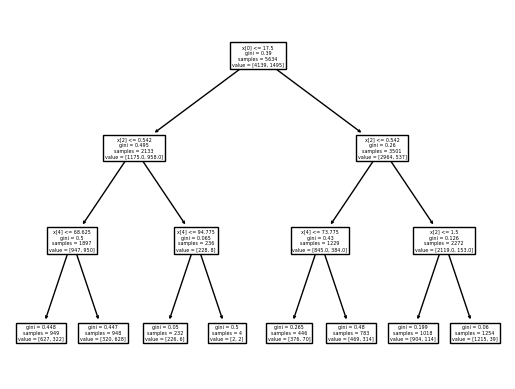

In [61]:
from sklearn import tree
tree.plot_tree(dt)

# Plot the correlations between features and targets
Here we analyze the correlations between features and targets, and we can see that the columns are very loosely correlated. Since each column doesn't tell much about whether a customer will churn or not, we could try to combine columns to create a more holistic analysis.

In [62]:
df.corrwith(df["Churn"])

tenure                   -0.352229
PhoneService              0.011942
Contract                 -0.394453
PaymentMethod            -0.262818
MonthlyCharges            0.193356
TotalCharges             -0.198324
Churn                     1.000000
TotalCharges_to_tenure    0.193301
dtype: float64

<Axes: >

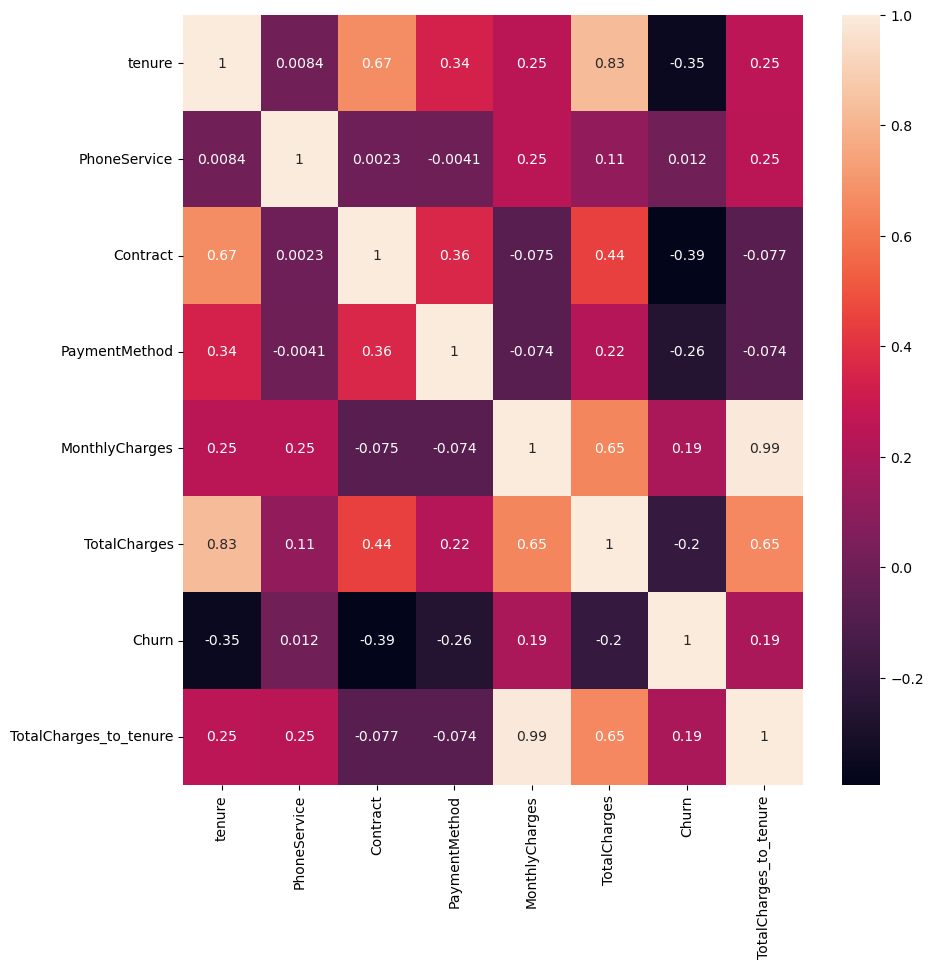

In [63]:
import seaborn as sns

f = plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)

# Use sklearn to fit a random forest model to predict churn from our dataset
We created a random forest model with max_depth and max_features of 3 to compare it with the decision tree model. Although random forest models perform better than decision tree models on average, our random forest model scored slightly worse than our decision tree model. I believe the reasons are because of the columns of our dataset are not strongly correlated and our single decision tree model is overfitting.

In [71]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=3, max_features=3, random_state=33)
rfc.fit(x_train, y_train)

print(rfc.score(x_train, y_train))
print(rfc.score(x_test, y_test))

0.7921547745828896
0.7764371894960965


In [65]:
opt_RF = BayesSearchCV(
    RandomForestClassifier(),
    {
        'max_depth': (3, 20),
        'n_estimators': (50, 500),
        'max_features': (3, 20),
        'min_samples_split': (2, 5)
    },
    n_iter=32,
    cv=3
)

np.int = int
opt_RF.fit(x_train, y_train)

print("val. score: %s" % opt_RF.best_score_)
print("test score: %s" % opt_RF.score(x_test, y_test))

val. score: 0.7958821441249556
test score: 0.7899219304471257


In [74]:
opt_RF.best_estimator_

RandomForestClassifier(max_depth=5, max_features=3, min_samples_split=5,
                       n_estimators=50)

# Plot the feature importances from the random forest
Since there are little correlations between each column and the target column. Our feature importance graph shows a lot of uncertainty.

<Axes: title={'center': 'Feature Importance'}>

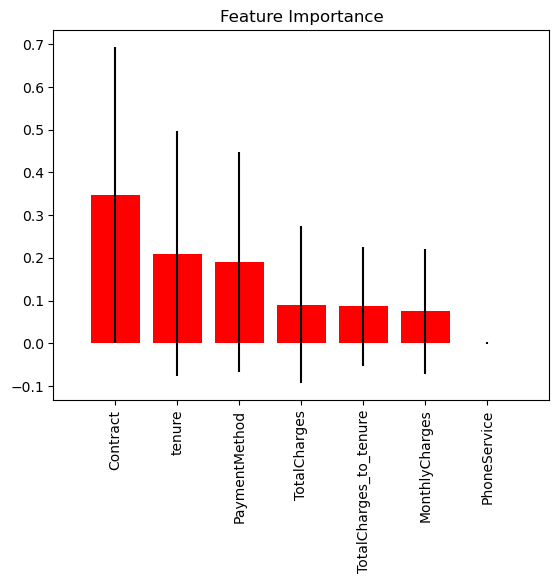

In [67]:
from scikitplot.estimators import plot_feature_importances

plot_feature_importances(rfc, feature_names=features.columns, x_tick_rotation=90)

# Choose some of the less-important features to remove from the model and fit the random forest model to the new data
After seeing the correlations and feature importances, I decided to remove lowest 4 columns from the dataset to compare it with the previous random forest model accuracy score. The model scores better now, but the trade-off is losing information. We could improve our dataset by combining columns to create more new information.

In [82]:
new_features = features.drop(['PhoneService', 'TotalCharges_to_tenure', 'MonthlyCharges', 'TotalCharges'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(new_features, targets, stratify=targets, random_state=9)

In [83]:
rfc = RandomForestClassifier(max_depth=3, max_features=3, random_state=33)
rfc.fit(x_train, y_train)

print(rfc.score(x_train, y_train))
print(rfc.score(x_test, y_test))

0.7724346838318819
0.7739920499716071


# Examine the feature importances after removing less important features
before removing the columns, the 'tenure' column was the second important feature. Now, the 'PaymentMethod' column replaced it as the second important feature. I believe the reason is because of narrowing down the dimension, reducing sparsity, and increasing the statistical significance of the training result.

<Axes: title={'center': 'Feature Importance'}>

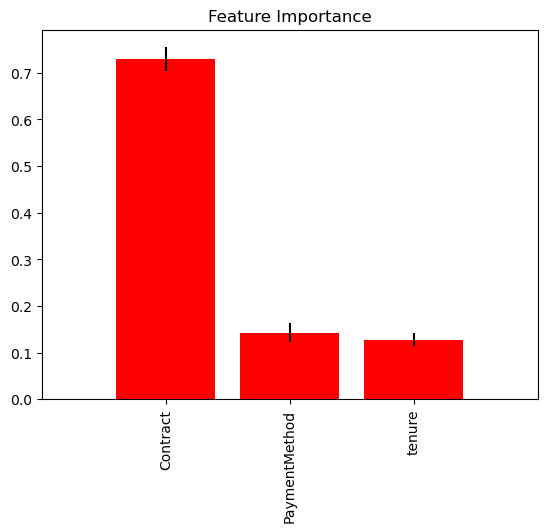

In [85]:
plot_feature_importances(rfc, feature_names=new_features.columns, x_tick_rotation=90)